In [1]:
from imp import reload

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns

from lib import IO
from lib import Loader
from lib import graph
from lib import pt_utils
from scipy.sparse import coo_matrix

plt.rcParams['figure.dpi'] = 100
serif = plt.rcParams['font.sans-serif']
# plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
# plt.rcParams['font.sans-serif'] = serif

reload(Loader)
reload(graph)
reload(IO)

<module 'lib.IO' from 'D:\\Projects\\ST_Attention\\lib\\IO.py'>

**od asfreq code**

---

    names = od.index.names
    od = od.groupby([pd.Grouper(level=names[0], freq=freq), names[1], names[2]]).sum()

## Case index

In [2]:
def get_time_index(od, start=8, end=22):
    datetime = od.index.levels[0]
    week_index = datetime[datetime.weekofyear == (datetime.weekofyear[0] + 2)]
    time_index = filter_time(week_index, start, end)
    return time_index

def filter_time(index, start, end):
    time_index = index[(index.hour >= start) & (index.hour < end)]
    return time_index

def get_period_index(datetime, period='last'):
    if period == 'last':
        return datetime - (datetime[1] - datetime[0])
    elif period == 'day':
        return datetime - pd.Timedelta(days=1)
    elif period == 'week':
        return datetime - pd.Timedelta(days=7)
    


In [3]:
def od_sum(ts_od):
    return ts_od.groupby(level=['Entry', 'Exit']).sum()


def od_norm(od):
    tmp = od.unstack()
    tmp /= tmp.sum()
    return tmp.stack()
    
    


## DATA

In [4]:
reload(Loader)
station = {}
station_flow = {}
road = {}
ts_od = {}
ts_od_ = {}
od = {}
index = {}
index_ = {}

for dataset in ['highway', 'metro']:
    loader = Loader.BJLoader(dataset)
    
    station[dataset] = loader.load_node()
    road[dataset] = loader.load_link()
    station_flow[dataset] = loader.load_ts_d().sum()
    
    ts = loader.load_ts_od(freq='15min')

    index[dataset] = get_time_index(ts, start=7, end=22)
    index_[dataset] = get_period_index(index[dataset])
    ts_od[dataset] = ts.loc[index[dataset], :, :]
    ts_od_[dataset] = ts.loc[index_[dataset], :, :]
    od[dataset] = od_sum(ts_od[dataset])
    
    del ts

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


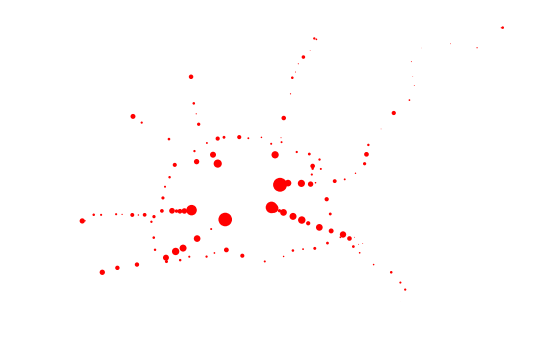

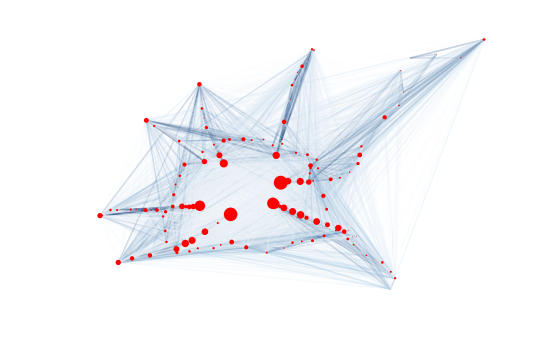

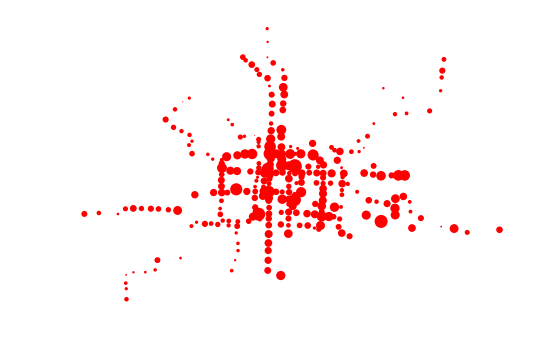

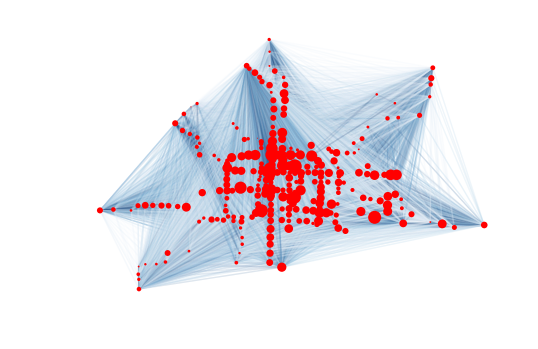

In [37]:
reload(graph)

for data in ['highway', 'metro']:
    G = graph.build_graph_node(station[data], station_flow[data])
    edges = od_norm(od[data])
    graph.add_sparse_edges(G, edges)
    
    graph.draw_nodes(G)
    plt.axis('off')
    plt.show()
    
    graph.draw_nodes(G)
    graph.draw_edges(G, edge_vmax=edges.mean())
    plt.axis('off')
    plt.show()


In [47]:
test = od['highway'].values
np.array(list(reversed(sorted(test))))

array([29067, 28817, 28295, ...,     1,     1,     1], dtype=int64)

In [65]:
print(132**2, 268**2)

17424 71824


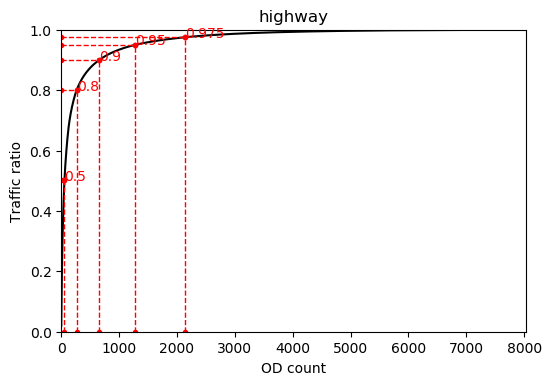

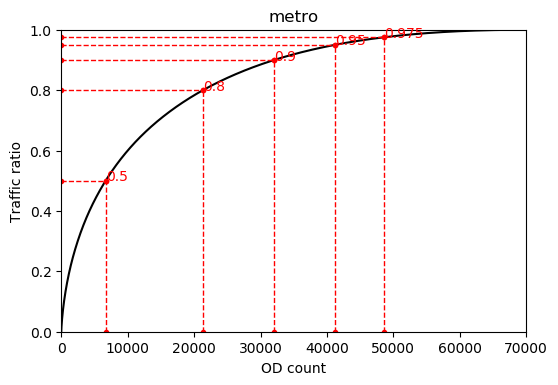

In [63]:
def od_cum(values):
    tmp = values / sum(values)
    tmp = np.array(list(reversed(sorted(tmp))))
    tmp = np.cumsum(tmp)
    return tmp


def plot_ratios(contrib, ratios):
    assert isinstance(ratios, list)
    for r in ratios:
        for x, y in enumerate(contrib):
            if y >= r:
                plt.text(x, y, s=str(r), color='red')
                plt.plot([0, x], [y, y], '.--', linewidth=1, color='red')
                plt.plot([x, x], [0, y], '.--', linewidth=1, color='red')
                break
                
    

for data in ['highway', 'metro']:
    contrib = od_cum(od[data])
    plt.plot(contrib, color='k')
    plt.xlim(0, len(contrib))
    plt.ylim(0, 1)
    plot_ratios(contrib, [0.5, 0.8, 0.9, 0.95, 0.975])
    plt.title(data)
    plt.xlabel('OD count')
    plt.ylabel('Traffic ratio')
    plt.show()

## Maths

In [67]:
def Hellinger(od1, od2):
    set1 = set(od1.index.tolist())
    set2 = set(od2.index.tolist())
    intersection = list(set1.intersection(set2))
    sumprod = od1.sum() * od2.sum()
    BC = sum(np.sqrt([od1[i] * od2[i] / sumprod for i in intersection]))
    return 1 - np.sqrt(1 - BC)


def Jaccard(od1, od2):
    set1 = set(od1.index.tolist())
    set2 = set(od2.index.tolist())
    intersection = list(set1.intersection(set2))
    union = set1.union(set2)
    return len(intersection) / len(union)


def Dice(od1, od2):
    if od1.sum() == 0 or od2.sum() == 0:
        return np.nan
    set1 = set(od1.index.tolist())
    set2 = set(od2.index.tolist())
    inter = list(set1.intersection(set2))
    return 2 * len(inter) / (len(set1) + len(set2))


def intersect_traffic(od1, od2):
    if od1.sum() == 0 or od2.sum() == 0:
        return np.nan
    set1 = set(od1.index.tolist())
    set2 = set(od2.index.tolist())
    inter = list(set1.intersection(set2))
    return (od1[inter].sum() + od2[inter].sum()) / (od1.sum() + od2.sum())

### OD Dice similarities

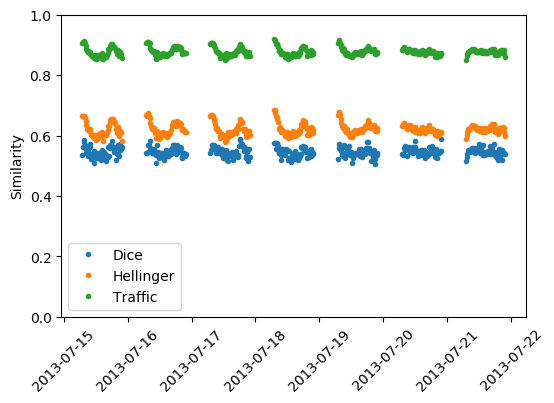

KeyboardInterrupt: 

In [72]:
plt.clf()
for data in ['highway', 'metro']:
    dice = [Dice(ts_od[data][i], ts_od_[data][j]) for i, j in zip(index[data], index_[data])]
    hellinger = [Hellinger(ts_od[data][i], ts_od_[data][j]) for i, j in zip(index[data], index_[data])]
    traffics = [intersect_traffic(ts_od[data][i], ts_od_[data][j]) for i, j in zip(index[data], index_[data])]
    
    plt.plot(index[data], dice, '.', label='Dice')
    plt.plot(index[data], hellinger, '.', label='Hellinger')
    plt.plot(index[data], traffics, '.', label='Traffic')
    plt.ylim(0, 1)
    plt.ylabel('Similarity')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.show()

### Stations' origins OD similarities

In [68]:
def similarity(func, od1, od2, index1, index2):
    return np.nanmean([func(od1[i], od2[j]) for i, j in zip(index1, index2)])

for data in ['highway', 'metro']:
    od1 = ts_od[data].reorder_levels([2, 0, 1])
    od2 = ts_od_[data].reorder_levels([2, 0, 1])
    index1, index2 = index[data], index_[data]
    
    dice = [similarity(Dice, od1, od2, index1, index2) for s in station[data]]
    hellinger = [similarity(Hellinger, od1, od2, index1, index2) for s in station[data]]
    traffic = [similarity(intersect_traffic, od1, od2, index1, index2) for s in station[data]]

    print(np.nanmean(d_dice), np.nanmean(d_hellinger), np.nanmean(d_traffics))

    traffic = station_flow[data]
    plt.scatter(d_dice, traffic, label='Dice')
    plt.scatter(d_hellinger, traffic, label='Hellinger')
    plt.scatter(d_traffics, traffic, label='Traffic')
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

KeyError: Timestamp('2013-07-15 07:00:00')

### visualizing these ODs

### how to use these ODs?

### how useful are these ODs?